In [2]:
import pandas as pd
from clickhouse_driver import Client
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import clickhouse_connect
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [88]:
pip install --upgrade nbformat nbconvert

  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4bc3cba53c9f038ab6e9ed964e22f1/nbformat-5.10.4-py3-none-any.whl.metadata
  Obtaining dependency information for nbconvert from https://files.pythonhosted.org/packages/b8/bb/bb5b6a515d1584aa2fd89965b11db6632e4bdc69495a52374bcc36e56cfa/nbconvert-7.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for mistune<4,>=2.0.3 from https://files.pythonhosted.org/packages/f0/74/c95adcdf032956d9ef6c89a9b8a5152bf73915f8c633f3e3d88d06bd699c/mistune-3.0.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   --------------- ------------------------ 30.7/78.5 kB 640.0 kB/s eta 0:00:01
   -------------------- ------------------- 41.0/78.5 kB 487.6 kB/s eta 0:00:01
   ------------------------------------ --- 71.7/78.5 kB 491.5 kB/s eta 0:00:01
   ---------------------------------------- 78.5/78.5 kB 483.8 kB/s eta 0:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires nbformat==5.9.2, but you have nbformat 5.10.4 which is incompatible.
conda-repo-cli 1.0.75 requires PyYAML==6.0.1, but you have pyyaml 6.0 which is incompatible.


In [21]:
####################################### full dataframe except number of friends ###############################################

In [59]:
%%time
def get_vk_member_info(group_id, token, version='5.131', fields='city,first_name,last_name,bdate,contacts,last_seen'):
    member_info = []
    offset = 0
    count = 1000
    while True:
        response = requests.get(
            'https://api.vk.com/method/groups.getMembers',
            params={
                'group_id': group_id,
                'offset': offset,
                'count': count,
                'fields': fields,
                'access_token': token,
                'v': version
            }
        ).json()
        
        if 'response' not in response:
            print(f"Ошибка при получении данных: {response}")
            break
        
        items = response['response']['items']
        member_info.extend(items)
        if len(items) < count:
            break
        offset += count
    return member_info

def calculate_age(bdate):
    try:
        birth_date = datetime.strptime(bdate, '%d.%m.%Y')
        today = datetime.now()
        return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    except:
        return None

def fetch_user_info(member):
    user_id_vk = member.get('id', None)
    fullname = f"{member.get('first_name', '')} {member.get('last_name', '')}".strip()
    city = member.get('city', {}).get('title', None)
    
    bdate = member.get('bdate', None)
    age = calculate_age(bdate) if bdate else None
    
    mobile_phone = member.get('mobile_phone', None)
    home_phone = member.get('home_phone', None)
    contacts = mobile_phone if mobile_phone else (home_phone if home_phone else None)
    
    last_seen_timestamp = member.get('last_seen', {}).get('time', None)
    last_seen = datetime.fromtimestamp(last_seen_timestamp).strftime('%Y-%m-%d %H:%M:%S') if last_seen_timestamp else None
    
    return user_id_vk, fullname, city, age, contacts, last_seen

def parallel_fetch_user_info(members, max_workers=20):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch_user_info, member): member['id'] for member in members}
        
        for future in as_completed(futures):
            try:
                result = future.result()
                if result:
                    results.append(result)
            except Exception as e:
                member_id = futures[future]
                print(f"Исключение в future для member_id {member_id}: {e}")
    return results

token = "my_token"  # Замените на ваш токен доступа
group_id = 'vk_fishing'

# Получение списка участников группы с дополнительной информацией
members = get_vk_member_info(group_id, token)

# Получение информации о пользователях
user_info = parallel_fetch_user_info(members)

# Преобразование результата в DataFrame pandas
df = pd.DataFrame(user_info, columns=['user_id_vk', 'fullname', 'city', 'age', 'contacts', 'last_seen'])

# Вывод DataFrame
print(df)


        user_id_vk               fullname      city   age contacts  \
0        341945000          Руслан Осипов      None   NaN     None   
1        231784688         Алексей Пятаев      None   NaN     None   
2        164702543               Ваня Рий  Дрогобыч  35.0     None   
3        547704350           Captain Memo      None  25.0     None   
4        325441591           Юрий Устинов  Темиртау  38.0     None   
...            ...                    ...       ...   ...      ...   
858290   359593306         Павел Максимов    Курган   NaN     None   
858291    55770254          Максим Витман      Омск   NaN     None   
858292   201017789        Максим Данченко   Полтава   NaN     None   
858293   127841001            Рома Мендак      None   NaN     None   
858294    25656645  Алексей Заенчуковский    Гродно   NaN     None   

                  last_seen  
0       2024-05-16 08:35:01  
1       2024-05-16 23:16:43  
2                      None  
3       2024-04-15 01:27:07  
4       2

In [60]:
df.nunique()

user_id_vk    858294
fullname      570332
city           18797
age              110
contacts       95145
last_seen     490822
dtype: int64

In [61]:
df_backup = df.copy()

In [73]:
df['age'] = df['age'].fillna(0)

,user_id_vk,fullname,city,age,contacts,last_seen
0,341945000,Руслан Осипов,None,0,None,2024-05-16 08:35:01
1,231784688,Алексей Пятаев,None,0,None,2024-05-16 23:16:43
2,164702543,Ваня Рий,Дрогобыч,35,None,None
3,547704350,Captain Memo,None,25,None,2024-04-15 01:27:07
4,325441591,Юрий Устинов,Темиртау,38,None,2019-09-09 22:27:18


In [74]:
df['age'] = df['age'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858295 entries, 0 to 858294
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id_vk  858295 non-null  int64 
 1   fullname    858295 non-null  object
 2   city        623893 non-null  object
 3   age         858295 non-null  int64 
 4   contacts    120450 non-null  object
 5   last_seen   806175 non-null  object
dtypes: int64(2), object(4)
memory usage: 39.3+ MB


In [77]:
df['last_seen'] = pd.to_datetime(df['last_seen'], errors='coerce')

In [80]:
df['last_seen'] = df['last_seen'].fillna(0)

In [1]:
df.info()

NameError: name 'df' is not defined

In [ ]:
####################################### deploying ClickHouse database ###############################################

In [82]:

# Подключение к ClickHouse
client = clickhouse_connect.get_client(
    host='my_host',
    user='default',
    password='my_password',
    secure=True
)

# Создание таблицы в ClickHouse
client.command('''
    CREATE TABLE IF NOT EXISTS vk_users (
        user_id_vk UInt64,
        fullname Nullable(String),
        city Nullable(String),
        age Nullable(Int32),
        contacts Nullable(String),
        last_seen Nullable(DateTime)
    ) ENGINE = MergeTree()
    ORDER BY user_id_vk
''')

# Преобразование DataFrame в список кортежей
data_tuples = [tuple(x) for x in df.to_numpy()]

# Вставка данных в таблицу vk_users
client.insert('vk_users', data_tuples, column_names=['user_id_vk', 'fullname', 'city', 'age', 'contacts', 'last_seen'])

# Проверка данных
result = client.query('SELECT * FROM vk_users')
print(result.result_rows)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
######################### looking for number of friends ##############################################################

In [14]:
%%time
def fetch_friends_counts(user_ids, token, version='5.131'):
    friends_counts = []
    batch_size = 25  # Количество запросов в одной партии для метода execute (до 25)
    
    for i in range(0, len(user_ids), batch_size):
        batch = user_ids[i:i + batch_size]
        
        # Формирование кода для метода execute
        code = 'return [' + ','.join(
            ['API.friends.get({"user_id":' + str(user_id) + '})' for user_id in batch]
        ) + '];'
        
        # Формирование URL и параметров для запроса к VK API
        url = 'https://api.vk.com/method/execute'
        params = {
            'code': code,
            'access_token': token,
            'v': version
        }
        
        # Выполнение запроса к VK API
        response = requests.get(url, params=params)
        result = response.json()
        
        # Обработка ответа и извлечение количества друзей
        if 'response' in result:
            for res in result['response']:
                if isinstance(res, dict) and 'count' in res:
                    friends_counts.append(res['count'])
                else:
                    friends_counts.append(None)
        else:
            print("Ошибка:", result)
            friends_counts.extend([None] * len(batch))
        
        # Задержка, чтобы не превышать лимит запросов
        time.sleep(0.1)
    
    return friends_counts


# Пример использования функции с реальными значениями
# Извлечение списка user_id из таблицы vk_users
result = client.query('SELECT user_id_vk FROM vk_users')
user_ids = [row[0] for row in result.result_rows]
user_ids = user_ids[1:5000]

# Токен доступа
token = "my_token"  # Замените на ваш токен доступа
version = '5.131'

# Получение количества друзей для каждого user_id
friends_counts = fetch_friends_counts(user_ids, token, version)

# Преобразование результатов в pandas серию
friends_count_series = pd.Series(friends_counts, index=user_ids)

# Проверка результата
print(friends_count_series)



367730464      NaN
367730623     27.0
367731068      NaN
367731819     43.0
367731954     45.0
             ...  
371917978      5.0
371919028    120.0
371919263    153.0
371920889      NaN
371921226      0.0
Length: 4999, dtype: float64
CPU times: total: 48.5 s
Wall time: 2min 42s


In [ ]:
# Добавление нового столбца friends_count в таблицу vk_users
client.command('ALTER TABLE vk_users ADD COLUMN IF NOT EXISTS friends_count Int32 DEFAULT -1')

# Подготовка данных для обновления
update_data = pd.DataFrame({
    'user_id_vk': friends_count_series.index,
    'friends_count': friends_count_series.fillna(-1).astype(int)
})

# Создание временной таблицы для обновления данных
client.command('CREATE TABLE IF NOT EXISTS vk_users_temp (user_id_vk Int32, friends_count Int32) ENGINE = Memory')

# Вставка обновленных данных во временную таблицу
client.insert_dataframe('vk_users_temp', update_data)

# Обновление данных в основной таблице из временной таблицы
client.command('ALTER TABLE vk_users UPDATE friends_count = vk_users_temp.friends_count FROM vk_users_temp WHERE vk_users.user_id_vk = vk_users_temp.user_id_vk')

# Удаление временной таблицы
client.command('DROP TABLE vk_users_temp')

In [ ]:
################################# getting top 5 names #################################################

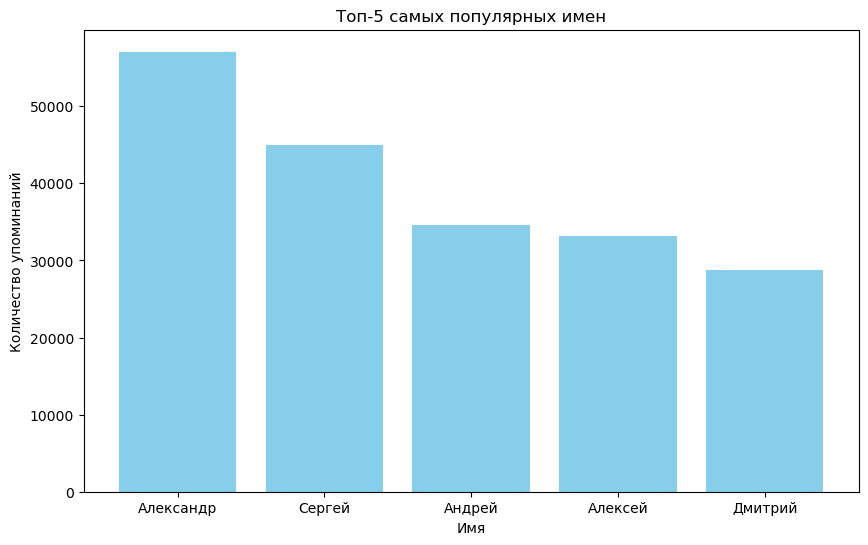

In [51]:
# SQL-запрос для нахождения топ-5 самых популярных имен
query = """
SELECT 
    substring(fullname, 1, position(fullname, ' ') - 1) AS first_name,
    count(*) AS name_count
FROM 
    vk_users
WHERE 
    position(fullname, ' ') > 0
GROUP BY 
    first_name
ORDER BY 
    name_count DESC
LIMIT 
    5
"""

# Выполнение запроса
result = client.query(query)

# Преобразование результата в DataFrame
data = pd.DataFrame(result.result_rows, columns=['first_name', 'name_count'])

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(data['first_name'], data['name_count'], color='skyblue')
plt.xlabel('Имя')
plt.ylabel('Количество упоминаний')
plt.title('Топ-5 самых популярных имен')
plt.show()

In [ ]:
### age-friends count scatterplot (5k)

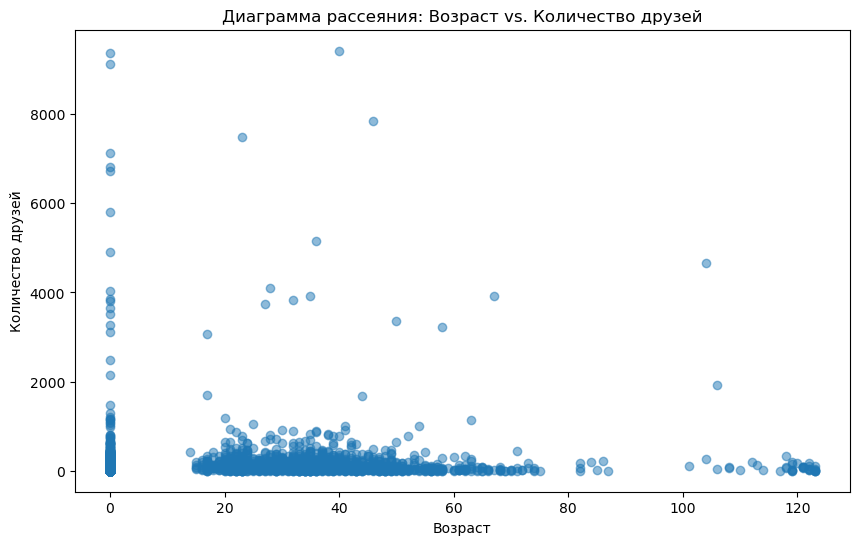

<Figure size 640x480 with 0 Axes>

In [85]:
# Диаграмма рассеяния: Количество лет vs. Количество друзей
scatter_plot_query = """
SELECT 
    age, 
    friends_count 
FROM 
    vk_users 
WHERE 
    age IS NOT NULL 
    AND friends_count >= 0
"""
scatter_plot_data = client.query(scatter_plot_query)
scatter_plot_df = pd.DataFrame(scatter_plot_data.result_rows, columns=scatter_plot_data.column_names)

plt.figure(figsize=(10, 6))
plt.scatter(scatter_plot_df['age'], scatter_plot_df['friends_count'], alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество друзей')
plt.title('Диаграмма рассеяния: Возраст vs. Количество друзей')
plt.show()

# Указание пути для сохранения графика
graph_file_path = os.path.join(os.getcwd(), 'scatter_plot.png')

# Сохранение графика в файл
plt.savefig(graph_file_path)

In [ ]:
### age-friends count scatterplot (5k) (less than 1000 friends)

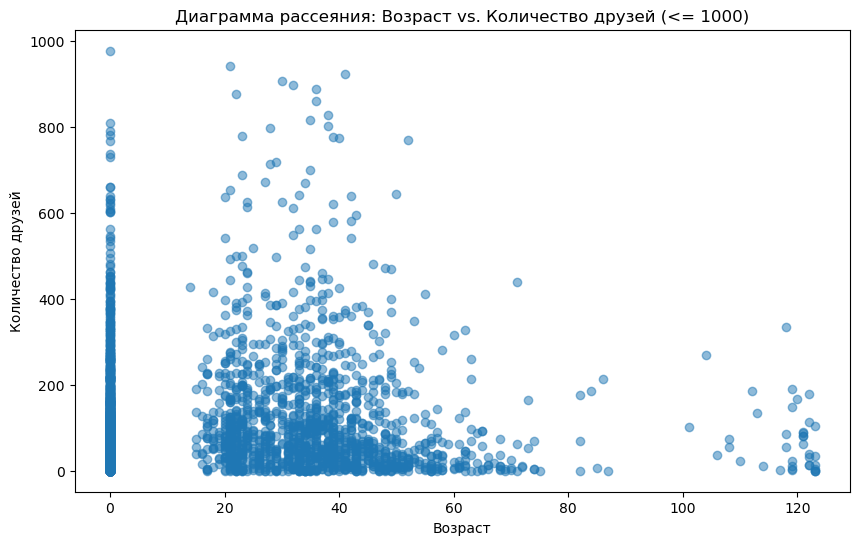

<Figure size 640x480 with 0 Axes>

In [86]:
# Фильтрация данных для новой диаграммы рассеяния (<= 1000 друзей)
filtered_df = scatter_plot_df[scatter_plot_df['friends_count'] <= 1000]

# Построение новой диаграммы рассеяния с ограничением на количество друзей
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['age'], filtered_df['friends_count'], alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество друзей')
plt.title('Диаграмма рассеяния: Возраст vs. Количество друзей (<= 1000)')
plt.show()

# Указание пути для сохранения графика
graph_file_path = os.path.join(os.getcwd(), 'scatter_plot_reduced.png')

# Сохранение графика в файл
plt.savefig(graph_file_path)

In [79]:
# Топ-3 города с наибольшим средним количеством друзей
top_cities_query = """
SELECT 
    city as "Город", 
    ROUND(AVG(friends_count) AS avg_friends, 0) as "Среднее количество друзей"
FROM 
    vk_users 
WHERE 
    city IS NOT NULL
    AND friends_count >= 0
GROUP BY 
    city
HAVING
    COUNT(*) > 5    
ORDER BY 
    avg_friends DESC 
LIMIT 3
"""
top_cities_data = client.query(top_cities_query)
top_cities_df = pd.DataFrame(top_cities_data.result_rows, columns=top_cities_data.column_names)

# Вывод топ-3 города
print("Топ-3 города с наибольшим средним количеством друзей (среди городов в которых больше 5 участников группы):")
print(top_cities_df)


Топ-3 города с наибольшим средним количеством друзей (среди городов в которых больше 5 участников группы):
          Город  Среднее количество друзей
0        Курган                     1356.0
1        Донецк                     1152.0
2  Магнитогорск                      785.0


In [ ]:
Самый часто встречаемый город

In [87]:
# SQL-запрос для нахождения самого часто встречаемого города
query = """
SELECT 
    city, 
    count(*) AS city_count
FROM 
    vk_users
WHERE city is not Null
GROUP BY 
    city
ORDER BY 
    city_count DESC
LIMIT 1
    
"""

# Выполнение запроса
result = client.query(query)

# Преобразование результата в DataFrame
data = pd.DataFrame(result.result_rows, columns=['city', 'city_count'])

# Вывод самого часто встречаемого города
most_common_city = data.iloc[0]
print(f"Самый часто встречаемый город: {most_common_city['city']} с количеством участников {most_common_city['city_count']}")


Самый часто встречаемый город: Москва с количеством участников 45350


In [ ]:
## downloading from ClickHouse Cloud

In [84]:
# Запрос для получения всех данных из таблицы vk_users
query = "SELECT * FROM vk_users"

# Выполнение запроса
data = client.query(query)

# Преобразование данных в DataFrame
column_names = data.column_names
data_df = pd.DataFrame(data.result_rows, columns=column_names)

# Проверка полученных данных
print(data_df.head())

# Указание пути для сохранения файла
csv_file_path = os.path.join(os.getcwd(), 'vk_users_data.csv')

# Сохранение данных в CSV файл
data_df.to_csv(csv_file_path, index=False)
print(f"Данные успешно сохранены в файл {csv_file_path}")

   user_id_vk         fullname             city  age contacts  \
0          48   Миша Мельников           Москва    0     None   
1        1018       Ярик Бурим  Санкт-Петербург    0     None   
2        1185  Алексей Могилов     Новомосковск    0     None   
3        1721    Максим Лоцока           Berlin   20     None   
4        2136   Ярослав Техник           Рязань    0     None   

            last_seen  friends_count  
0 1970-01-01 00:00:00             -1  
1 2021-02-19 09:15:36             -1  
2 1970-01-01 00:00:00             -1  
3 1970-01-01 00:00:00             -1  
4 2022-09-30 00:13:26             -1  
Данные успешно сохранены в файл C:\Users\logo_\vk_users_data.csv
